# Анализ продаж онлайн магазина "Стримчик"

Задача на проект: анализ продаж игр разных платформ на основании находящихся в открытом источнике данных, поиск закономерностей, определяющих успешность игр, благодаря котором можно предугадать спрос на последующие года, а значит заранее подготовится.

План работы:

1) [Изучить общую информацию (посмотреть доступные данные, проанализировать датафрейм, составить план обработки данных)](#id_1)

2) [Обработать данные (заполнить пропуски, поменять форматы, выделить ключевые шаги и действия, провести все необходимые рассчеты)](#id_2)

3) [Исследовательская работа (определение актуального периода анализа, популярных платформ и жанров, поиск закономерностей, которые помогут нам при планировании дальнейшей работы).](#id_3)

4) [Составить портрет пользователей разных регионов (Европа, Япония, Северная Америка)](#id_4)

5) [Построить и проверить некоторые гипотезы](#id_5)

6) [Общий вывод по результатам всей работы](#id_6)

<a id='id_1'></a>
# 1) Изучение общей информации

In [1]:
# запустим все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import seaborn as sns

In [2]:
# загрузим файл
data = pd.read_csv ('/datasets/games.csv')
data.info()
data.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Всего 11 колонок и 16715 строк. 

__Name__ - название игры, у 2 игр названия отсутствуют, самостоятельно восстановить не удастся, для статистики названия не нужны, а значит пропуски заменяем на unnamed. Возможно, выбросы или ошибка при заполнении. 

__Platform__ - платформа, строки заполнены все, формат устраивает, проверяем регистр.

__Year_of_Realese__ - год выпуска игры, данные заполнены не все (16446 из 16715), для аналитики год нужен будет не всегда, а значит для удобства ___пропуски заменим на 0___, при аналитике, например, по годам - данные можно будет удалить. ___Приводим столбец к формату int___. Скорее всего данные были потеряны при интеграции или заполнении.

__Genre__ - жанр, есть 2 пропуска, при возможности данные можно самостоятельно подтянуть из интернета (данные находятся в открытом доступе, пропусков мало и заполнение будет не таким энергозатратным). В данном проекте предлагаю заменить пропуски на not_genres либо просто удалить строки (их всего 2, сильно на статистику не повлияет). Скорее всего данные просто не были указаны при заполнении.

__NA_sales, EU_sales, JP_sales, Other_sales__ - продажи в Северной Америке, Европе, Японии и в остальных регионах указанные в миллионах штук. Формат не меняем, строки заполнены все. 

__Critic_Score__ - оценка критиками по 100-бальной шкале. Очень много пропусков (заполнено 8137 из 16715). Заполнить средним или медианным значением - значит сильно исказить статистику, ___пропуски заменяем на 0, формат меняем на int___.

__User_Score__ - оценка пользователями по 10-бальной шкале. Для удобства сравнения с оценкой критиками - ___переведем к 100-бальной шкале, формат меняем на int___. По аналогии с Critic_Score - ___заменяем пропуски на 0___ (т.к. пропусков слишком много и статистика так же будет искажена).

__Rating__ - возрастной рейтинг, формат устраивает, пропуски заменяем на not_rating. 

Как можно заметить - очень сильно пропущены значения в столбцах с оценками и рейтингом. Скорее всего данные либо не были занесены, либо на момент выпуска игры такие статистики не велись/не учитывались. Более детально ознакомимся со столбцами позднее. 

Так же для удобства переведем название колонок к нижнему регистру

<a id='id_2'></a>
# 2) Предобработка данных

In [3]:
# приведем названия колонок к нижнему регистру
data.columns = data.columns.str.lower()
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# приведем колонку с платформами к нижнему регистру
data['platform'] = data['platform'].apply(str.lower)
data.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,nes,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,gb,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,gb,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,ds,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,nes,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [5]:
# в столбце год релиза заменим пропуски на 0, столбец приведем к формату int
data['year_of_release'] = data['year_of_release'].fillna(0).apply(int)
data.query('year_of_release == 0').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,269.0,269.000000,269.000000,269.000000,269.000000,154.000000
mean,0.0,0.219888,0.090929,0.024907,0.032007,67.584416
std,0.0,0.424907,0.207933,0.090160,0.075546,14.828740
min,0.0,0.000000,0.000000,0.000000,0.000000,22.000000
25%,0.0,0.010000,0.000000,0.000000,0.000000,57.000000
50%,0.0,0.090000,0.020000,0.000000,0.010000,70.000000
75%,0.0,0.240000,0.100000,0.000000,0.030000,78.000000
max,0.0,4.260000,2.360000,0.770000,0.710000,94.000000


Сравним статистику игр без года релиза с играми, у которых год релиза указан

In [6]:
data.query('year_of_release != 0').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446.000000,16446.000000,16446.000000,16446.000000,16446.000000,7983.000000
mean,2006.484616,0.264089,0.145945,0.078479,0.047593,68.994363
std,5.877050,0.818416,0.506696,0.311082,0.187994,13.920060
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Интересный факт - игры, у которых год релиза не указан - в большинстве случаев не продавались на территории Японии (как минимум 75% таких игр в продаже не были), в то время как в других регионах разница практически небольшая.

Так же, можно заметить что в каждом регионе как минимум 25% от игр не продавались вообще, возможно имеет значение формат приставки или жанр игр, в каждом регионе свои предпочтения?

In [7]:
# обработаем столбец с жанрами
data['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

In [8]:
data['genre'] = data['genre'].fillna('not_genres').apply(str.lower)
data['genre'].value_counts()

action          3369
sports          2348
misc            1750
role-playing    1498
shooter         1323
adventure       1303
racing          1249
platform         888
simulation       873
fighting         849
strategy         683
puzzle           580
not_genres         2
Name: genre, dtype: int64

В столбце user_score есть значение 'tbd', которое не дает нам обработать столбец. Попробуем выяснить причины появления этого значения. 

In [9]:
data.query('user_score == "tbd"' and 'year_of_release != 0').head(30)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,wii,2009,platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,nes,1984,shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [10]:
data.query('user_score != "tbd"').head(30)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,wii,2009,platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,nes,1984,shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [11]:
data.query('user_score == "tbd"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2424 entries, 119 to 16706
Data columns (total 11 columns):
name               2424 non-null object
platform           2424 non-null object
year_of_release    2424 non-null int64
genre              2424 non-null object
na_sales           2424 non-null float64
eu_sales           2424 non-null float64
jp_sales           2424 non-null float64
other_sales        2424 non-null float64
critic_score       1082 non-null float64
user_score         2424 non-null object
rating             2374 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 227.2+ KB


Какие можно сделать выводы:

    1) tbd - аббривеатура, самые часто встречаемые значения To Be Determined (будет определено) или To Be Deleted (было удалено), что означает следующее: либо оценок пользователей слишком мало для составления среднего рейтинга, либо данные по  каким-либо причинам были удалены. Данную информацию следует уточнить у людей, предоставивших статистику.         
    
    2) В условиях практической работы уточнить информацию у нас возможности нет, а значений у нас 2424. Удаление значений приведет к существенному изменению в статистике, например если нас интересуют продажи в штуках по определенным жанрам. А  значит делаем по аналогии с пропусками, значения tbd приравниваем к 0.
    
    3) Появилась следующая гипотеза: если рейтинг критиков не указан, то так же не указан и рейтинг пользователей, и         наоборот. Возможно, есть еще связь и с возврастным рейтингом?         

In [12]:
# заменяем значения tbd на 0
data['user_score'] = data['user_score'].replace('tbd', 0)

In [13]:
# обработаем столбцы critic_score и user_score, пропуски заменяем на 0, user_score умножаем на 10, приводим все к формату int
data['critic_score'] = data['critic_score'].fillna(0).apply(int)
data['user_score'] = data['user_score'].fillna(0).apply(float)
data['user_score'] = data['user_score']*10
data['user_score'] = data['user_score'].apply(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null int64
user_score         16715 non-null int64
rating             9949 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 1.4+ MB


In [14]:
# обрабатываем пропуски в столбцах name и rating
data['rating'] = data['rating'].fillna('not_rating')
data['name'] = data['name'].fillna('unnamed')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null int64
user_score         16715 non-null int64
rating             16715 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 1.4+ MB


In [15]:
# посчитаем сумарные продажи
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,80,E,82.54
1,Super Mario Bros.,nes,1985,platform,29.08,3.58,6.81,0.77,0,0,not_rating,40.24
2,Mario Kart Wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,83,E,35.52
3,Wii Sports Resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,80,E,32.77
4,Pokemon Red/Pokemon Blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,0,0,not_rating,31.38
5,Tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,0,0,not_rating,30.26
6,New Super Mario Bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89,85,E,29.80
7,Wii Play,wii,2006,misc,13.96,9.18,2.93,2.84,58,66,E,28.91
8,New Super Mario Bros. Wii,wii,2009,platform,14.44,6.94,4.70,2.24,87,84,E,28.32
9,Duck Hunt,nes,1984,shooter,26.93,0.63,0.28,0.47,0,0,not_rating,28.31


In [16]:
# проверим, есть ли игры с 0 продажами
data.query('all_sales == 0').head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16676,G1 Jockey 4 2008,ps3,2008,sports,0.0,0.0,0.0,0.0,0,0,not_rating,0.0
16709,SCORE International Baja 1000: The Official Game,ps2,2008,racing,0.0,0.0,0.0,0.0,0,0,not_rating,0.0


In [17]:
# такие данные следует считать выбросами, вероятная причина - статистика была внесена не полностью, 
# либо часть данных была потеряна. Удаляем
data = data.query('all_sales != 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null int64
user_score         16713 non-null int64
rating             16713 non-null object
all_sales          16713 non-null float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.7+ MB


In [18]:
# проверим список игр, у которых название не было указано
data.query('name == "unnamed"').head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
659,unnamed,gen,1993,not_genres,1.78,0.53,0.00,0.08,0,0,not_rating,2.39
14244,unnamed,gen,1993,not_genres,0.00,0.00,0.03,0.00,0,0,not_rating,0.03


Совершенно 2 разных игры, но с одной платформой, отсутствием рейтинга и одинаковым годом выпуска. Вполне вероятно что данные просто были внесены некорректно, а значит игры без названия можно спокойно удалять, потеря 2 значений сильно на статистику не повлияет. 

In [19]:
data = data.query('name != "unnamed"')

In [20]:
# проверим количество игр без рейтинга
data.query('rating == "not_rating"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6762 entries, 1 to 16714
Data columns (total 12 columns):
name               6762 non-null object
platform           6762 non-null object
year_of_release    6762 non-null int64
genre              6762 non-null object
na_sales           6762 non-null float64
eu_sales           6762 non-null float64
jp_sales           6762 non-null float64
other_sales        6762 non-null float64
critic_score       6762 non-null int64
user_score         6762 non-null int64
rating             6762 non-null object
all_sales          6762 non-null float64
dtypes: float64(5), int64(3), object(4)
memory usage: 686.8+ KB


Игр, у которых рейтинг не указан - слишком много, а значит удалять их - сильно повлиять на статистику. Оставляем без изменений.

In [21]:
# Проверим дубликаты, при их наличии - удаляем.
data.duplicated().sum()

0

### Вывод: итак, таблица готова к анализу, но следует не забывать что часть данных у нас заменена на 0, при анализе пропуски стоит удалять.

<a id='id_3'></a>
# 3) Исследовательский анализ данных

Посчитаем количество выпущенных игр в штуках по годам.

In [22]:
# Не забываем удалить нулевые зночения в столбце год релиза
data.query('year_of_release != 0').groupby('year_of_release')['all_sales'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1425
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: all_sales, dtype: int64

In [23]:
# так же посчитаем продажи игр по годам
data.query('year_of_release != 0').groupby('year_of_release')['all_sales'].sum()

year_of_release
1980     11.38
1981     35.68
1982     28.88
1983     16.80
1984     50.35
1985     53.95
1986     37.08
1987     21.70
1988     47.21
1989     73.45
1990     49.37
1991     32.23
1992     76.16
1993     45.99
1994     79.23
1995     88.12
1996    199.15
1997    201.07
1998    256.31
1999    251.11
2000    201.66
2001    331.46
2002    394.97
2003    357.54
2004    418.68
2005    457.82
2006    517.71
2007    604.75
2008    671.50
2009    658.82
2010    590.13
2011    507.58
2012    355.84
2013    361.24
2014    331.53
2015    267.98
2016    129.94
Name: all_sales, dtype: float64

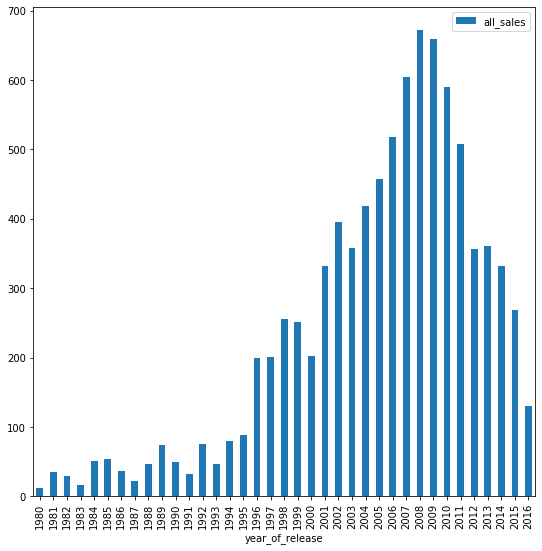

In [24]:
data_year_sales_sum = data.query('year_of_release != 0').pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
data_year_sales_sum.plot(kind='bar', figsize=(9, 9))

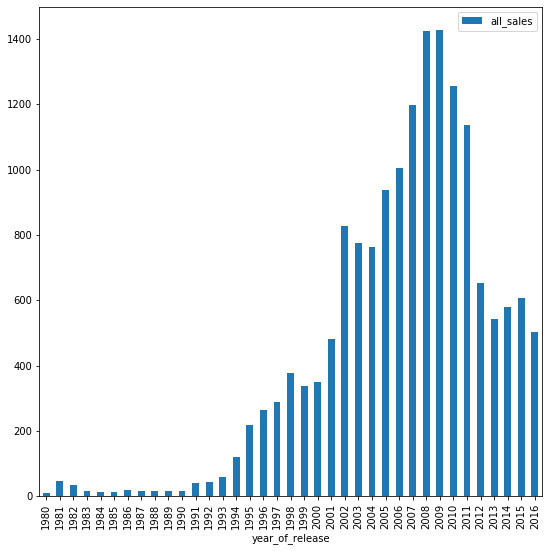

In [25]:
data_year_sales_count = data.query('year_of_release != 0').pivot_table(index='year_of_release', values='all_sales', aggfunc='count')
data_year_sales_count.plot(kind='bar', figsize=(9, 9))

До 1994 года в штуках выпускалось куда меньше игр, чем начиная с 1994 (количество не доходило до ста). Основной пик в штуках с 2005 по 2011, по сумме с 2001 по по 2011, после чего заметен резкий спад с 2012 года (как по штукам так и по сумме). Если брать за основу достовернность данных по продажам с 2012 по 2015 год , т.к. 2016 у нас еще не закончился и список не полностью окончен - заметен резкий спад. Вероятных причиных может быть 3: это либо пользователи начали покупать игры на игровых платформах в режимах онлайне (например steam для PC или PS Store для Sony Playstation), либо акцент сменился с количества, на качество (производители перестали штамповать простые быстропроходимые игры заменив их на более качественные и продуманные), либо акцент пользователей сместился на онлайн игры, в которые можно играть по времени чуть дольше чем в обычные, т.к. игроки не ограничены основным сюжетом или компанией.

In [26]:
#прежде чем строить графики - найдем самые продаваемые платформы и сделаем вырезку по ним
data.query('year_of_release != 0').groupby('platform')['all_sales'].sum().sort_values(ascending=False).head(15)

platform
ps2     1233.56
x360     961.24
ps3      931.34
wii      891.18
ds       802.78
ps       727.58
ps4      314.14
gba      312.88
psp      289.53
3ds      257.81
pc       255.76
gb       254.43
xb       251.57
nes      251.05
n64      218.01
Name: all_sales, dtype: float64

Определим самые продаваемые по сумме платформы: ps2, x360, ps3, wii, ds, ps.

In [27]:
# посчитаем количество продаж по платформам по годам
data_plat_year = data.query('year_of_release != 0').pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
data_plat_year.head(40)

platform,2600,3do,3ds,dc,ds,gb,gba,gc,gen,gg,...,sat,scd,snes,tg16,wii,wiiu,ws,x360,xb,xone
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980,11.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,35.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,28.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,5.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,0.45,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,1.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,0.74,NaN,NaN,NaN,NaN,1.43,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# выберем самые продаваемые платформы
data_plat_year = data_plat_year[{'ps2', 'x360', 'ps3', 'wii', 'ds', 'ps'}]
data_plat_year.head(15)

platform,ps3,ps,wii,x360,ps2,ds
year_of_release,,,,,,
1980,NaN,NaN,NaN,NaN,NaN,NaN
1981,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,0.02
1986,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN


Интересно, но в платформе ds в 1985 году числятся продажи, хотя в последующие 8 лет продаж нет вообще. Очевидная ошибка в данных, для отсутствия искажения статистики - построем график с 1994 (начало продаж самых подаваемых платформ)

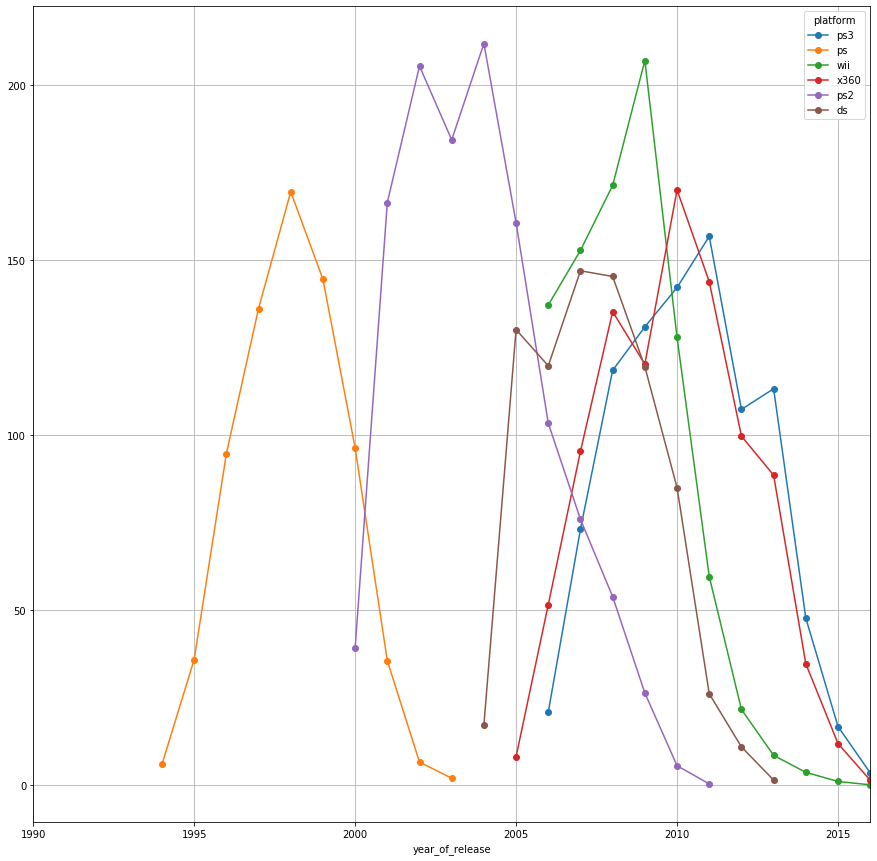

In [29]:
# создадим график продаж
data_plat_year.query('year_of_release >= 1990').plot(grid=True, figsize=(15, 15), style='o-')

### Вывод: 
В среднем платформы остаются актуальными на протяжении 10 лет, самый пик у них приходится на 3-5 года существования, после чего в основном становится заметен спад по продажам. В среднем, платформы обновляются раз в 5 лет.

__Для актуального анализа нам понадобится период с 2011 года по 2015, когда спад по сумме и штукам не такой сильный. Промежутка в 5 лет как раз будет достаточно, чтобы понять какие платформы новые и развиваются, а какие пошли на спад или вообще перестали нас интересовать, 2016 год нам не подходит, потому что сильно заметна разница по продажам, а значит данные по 2016 году у нас не полные и они могут исказить статистику. Но наличие в статистике 2016 покажет соотношение в текущем году, поэтому 2016 год тоже добавим, но по нему рост/падение рассчитывать не будем.__

In [30]:
# создадим отдельную табличку, где будут посчитано среднее время продолжительности.
data_plat_year2 = data.query('year_of_release != 0').pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
# сделаем вырезку из 15 самых продаваемых платформ
data_plat_year2 = data_plat_year2[{'ps2', 'x360', 'ps3', 'wii', 'ds', 'ps', 'ps4', 'gba', 'psp', '3ds', 'pc', 'gb', 'xb', 'nes', 'n64', 'xone'}]
# если сделать выгрузка из последних значений в таблице - можно увидеть, какие платформы все еще продаются и не подходят для анализа
data_plat_year2.tail(15)

platform,xone,ps3,ps4,gb,3ds,xb,nes,n64,psp,ps,wii,gba,x360,ps2,pc,ds
year_of_release,,,,,,,,,,,,,,,,
2002,NaN,NaN,NaN,NaN,NaN,48.01,NaN,0.08,NaN,6.67,NaN,74.16,NaN,205.38,8.57,NaN
2003,NaN,NaN,NaN,NaN,NaN,55.04,NaN,NaN,NaN,2.07,NaN,56.67,NaN,184.31,8.84,NaN
2004,NaN,NaN,NaN,NaN,NaN,65.42,NaN,NaN,7.06,NaN,NaN,77.91,NaN,211.81,10.39,17.27
2005,NaN,NaN,NaN,NaN,NaN,49.08,NaN,NaN,43.84,NaN,NaN,33.86,8.25,160.66,4.37,130.14
2006,NaN,20.96,NaN,NaN,NaN,10.04,NaN,NaN,55.32,NaN,137.15,5.28,51.62,103.42,2.85,119.81
2007,NaN,73.19,NaN,NaN,NaN,0.55,NaN,NaN,46.93,NaN,152.77,3.40,95.41,75.99,9.28,146.94
2008,NaN,118.52,NaN,NaN,NaN,0.18,NaN,NaN,34.55,NaN,171.32,NaN,135.26,53.90,12.42,145.31
2009,NaN,130.93,NaN,NaN,NaN,NaN,NaN,NaN,37.78,NaN,206.97,NaN,120.29,26.40,16.91,119.54
2010,NaN,142.17,NaN,NaN,NaN,NaN,NaN,NaN,35.04,NaN,127.95,NaN,170.03,5.64,24.28,85.02


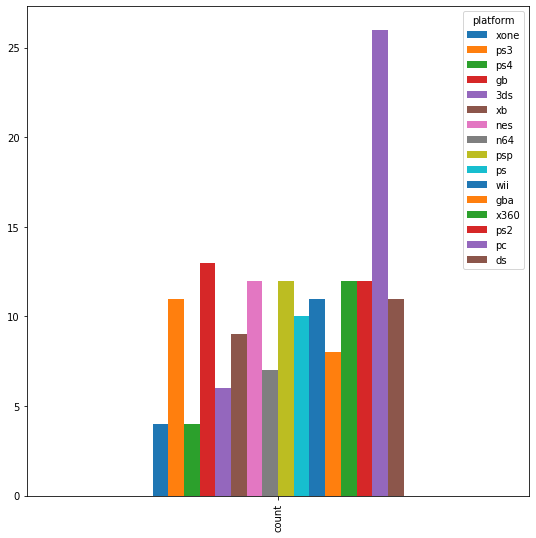

In [31]:
data_plat_year2.describe().head(1).plot(kind='bar',figsize=(9, 9))

In [32]:
data_plat_year2.describe().head(1)

platform,xone,ps3,ps4,gb,3ds,xb,nes,n64,psp,ps,wii,gba,x360,ps2,pc,ds
count,4.0,11.0,4.0,13.0,6.0,9.0,12.0,7.0,12.0,10.0,11.0,8.0,12.0,12.0,26.0,11.0


### Вывод:
Исходя из графика - можно выделить несколько аномальных значений:

    - слишком высокое значение (pc, в отличии от игровых приставок, не меняет свою платформу и соответственно остается      актуальной всегда)  
    
    - слишком низкие значения (ps4, xone, 3ds - это те приставки, которые получили популярность относительно недавно, а     значит время популярности у них еще неполное).
    
Если рассчитывать среднее время без данных выбросов - в среднем платформы популярны на протяжении 11 лет. 

### Выбор периода анализа

In [33]:
# возвращаемся к исходному датафрейму data
data = data.query('2011 <= year_of_release <= 2016').reset_index(drop=True)
data.info()
data.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 12 columns):
name               4022 non-null object
platform           4022 non-null object
year_of_release    4022 non-null int64
genre              4022 non-null object
na_sales           4022 non-null float64
eu_sales           4022 non-null float64
jp_sales           4022 non-null float64
other_sales        4022 non-null float64
critic_score       4022 non-null int64
user_score         4022 non-null int64
rating             4022 non-null object
all_sales          4022 non-null float64
dtypes: float64(5), int64(3), object(4)
memory usage: 377.2+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Grand Theft Auto V,ps3,2013,action,7.02,9.09,0.98,3.96,97,82,M,21.05
1,Grand Theft Auto V,x360,2013,action,9.66,5.14,0.06,1.41,97,81,M,16.27
2,Call of Duty: Modern Warfare 3,x360,2011,shooter,9.04,4.24,0.13,1.32,88,34,M,14.73
3,Call of Duty: Black Ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,0,0,not_rating,14.63
4,Pokemon X/Pokemon Y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,0,0,not_rating,14.60
5,Call of Duty: Black Ops II,ps3,2012,shooter,4.99,5.73,0.65,2.42,83,53,M,13.79
6,Call of Duty: Black Ops II,x360,2012,shooter,8.25,4.24,0.07,1.12,83,48,M,13.68
7,Call of Duty: Modern Warfare 3,ps3,2011,shooter,5.54,5.73,0.49,1.57,88,32,M,13.33
8,Mario Kart 7,3ds,2011,racing,5.03,4.02,2.69,0.91,85,82,E,12.65
9,Grand Theft Auto V,ps4,2014,action,3.96,6.31,0.38,1.97,97,83,M,12.62


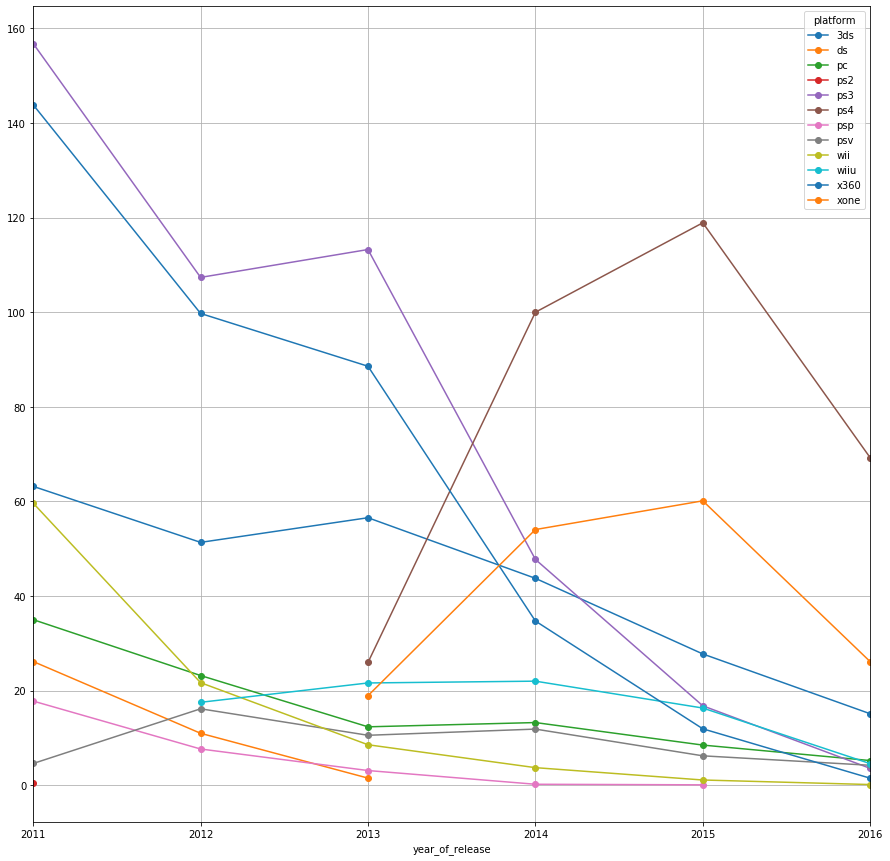

In [34]:
data_plat_year_new = data.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
data_plat_year_new.plot(grid=True, figsize=(15, 15), style='o-')

По продажам в безусловных лидерах ps4 (почти 120 млн копий), следом идет xone (60 млн копий) на 2015 год, 2016 мы не учитываем в связи с неполным объемом данных (согласно статистике соотношение сохраняется и на 2016 год, лидеры и отстющие не поменялись). Больше 20 млн копий в продажах сделала так же платформа 3ds. Все остальные платформы либо уже спустились к уровню 0, либо стремятся к нему. Самые сильные потери за пятилетку были у платформа ps3 и x360, что обусловлено выходом новой версии платформ (ps4 и xone соответственно). 
Для анализа статистики нас интересуют платформы xone и ps4, они все еще растут и подходят к своему пику (согласно статистике самый пик приходится на 3-5 года). Платформы же к концу 2016 будут на 3 году своего развития.

### Диаграмма размаха

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


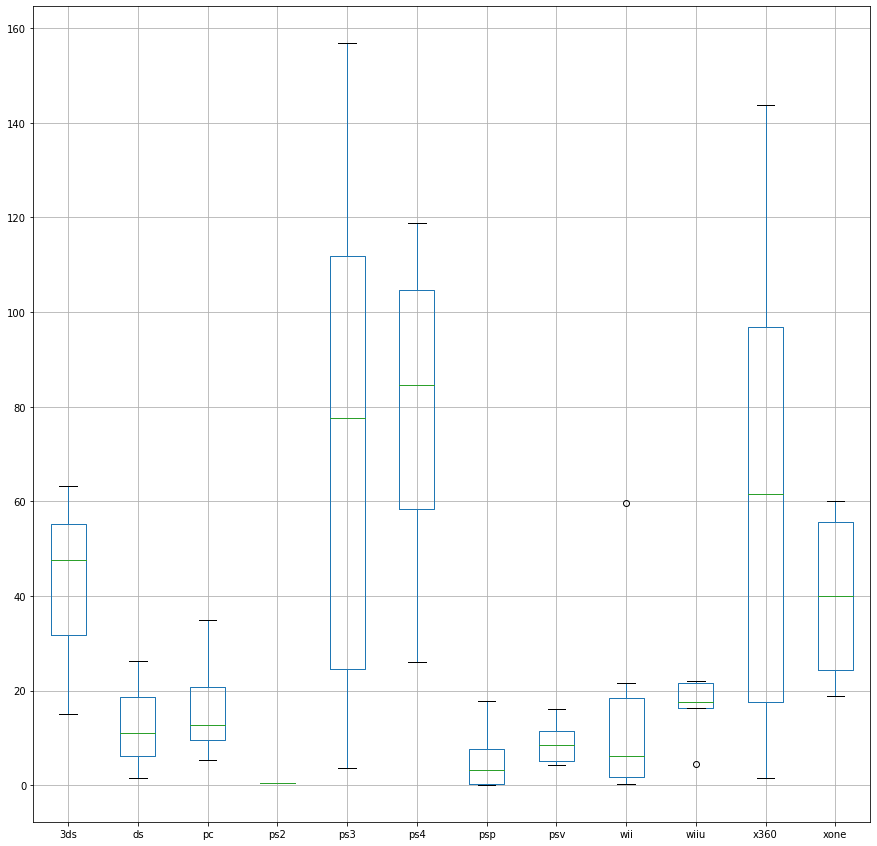

In [35]:
# построим диаграмму размаха с разбивкой по платформам по годам (или по-другому ящик с усами)
data_plat_year_new.boxplot(figsize=(15,15))

Диаграмма размаха может рассказать нам о многом, например - минимальный или максимальный размах, чем они выше - тем большим спросос пользовалась платформа. Можно так же обратить внимание на выбросы, которые четко указываются у каждого столбца. Чем больше диаграмма размаха - тем большая разница в значениях была на разных промежутках пользования, значения с небольшими размерами диаграммы всегда были примерно на одном уровне.

Безусловно, лидеры в штуках до сих пор ps3 и x360, но это всего-лишь связано с тем, что они прошли весь период, от подъема до спада (минимальный размах близок к 0). С другой стороны ps4 начала с больших продаж и находится на большом пике. У платформы xone показатели не такие сильные, и не смотря на то, что продажи до сих пор увеличиваются, она отстается от ps4. Интересная статистика у платформы 3ds, судя по минимальному размаху - платформа весь период пользовалась достаточным спросом у пользователей, продажи не близились у нулю.

У нас так же есть 2 выборса, выброс у платформы wii (в наш период попало 1 пиковое значения, после чего резкий спад, потому и появился резкий выброс), а так же wiiu - но тут выброс характеризуется низкими продажами в 2016, возможно из-за неполной статистики за год, потому и такое маленькое значение. 


Такие платформы как ps3 и х360 являются одними из лидеров на рынке, т.к. они по сути наиболее удобные для пользователей, на них выходит большинство игр, у них развитый мультиплеер, на них выходит много эксклюзивных игр, они владеют самыми развитыми технологиями. Все это делает их лидерами на рынке. 
    
С другой стороны - ps4 и xone (те платформы, которые сейчас развиваются) - это по своей сути просто новые версии платформ ps3 и x360 соотвественно. А значит - они постепенно вытесняют свою старую версию и будут занимать примерно аналогичные места по продажам.


### Анализ продаж на уровне платформ

Проанализируем продажи самой популярной платформы - ps4.

In [36]:
data_ps4 = data.query('platform == "ps4"')
data_ps4.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
3,Call of Duty: Black Ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,0,0,not_rating,14.63
9,Grand Theft Auto V,ps4,2014,action,3.96,6.31,0.38,1.97,97,83,M,12.62
20,FIFA 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82,43,E,8.58
23,Star Wars Battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,0,0,not_rating,7.98
24,Call of Duty: Advanced Warfare,ps4,2014,shooter,2.81,3.48,0.14,1.23,83,57,M,7.66
25,FIFA 17,ps4,2016,sports,0.66,5.75,0.08,1.11,85,50,E,7.60
30,Fallout 4,ps4,2015,role-playing,2.53,3.27,0.24,1.13,87,65,M,7.17
40,FIFA 15,ps4,2014,sports,0.80,4.33,0.05,0.90,82,57,E,6.08
42,Destiny,ps4,2014,shooter,2.49,2.07,0.16,0.92,76,61,T,5.64
45,Uncharted 4: A Thief's End,ps4,2016,shooter,1.85,2.50,0.19,0.85,93,79,T,5.39


In [37]:
# для удобства уберем все лишние столбцы, оставив только отзывы критиков, пользователей и суммарные продажи.
data_ps4_score = data_ps4[{'critic_score', 'user_score', 'all_sales'}]
data_ps4_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 3 to 3960
Data columns (total 3 columns):
critic_score    392 non-null int64
user_score      392 non-null int64
all_sales       392 non-null float64
dtypes: float64(1), int64(2)
memory usage: 12.2 KB


In [38]:
# удалим нулевые значения (те значения, у которых не были указаны оценки пользователей и критиков)
data_ps4_score = data_ps4_score.query('user_score != 0' and 'critic_score != 0')
data_ps4_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 9 to 3937
Data columns (total 3 columns):
critic_score    252 non-null int64
user_score      252 non-null int64
all_sales       252 non-null float64
dtypes: float64(1), int64(2)
memory usage: 7.9 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0a4065410>,
      dtype=object)

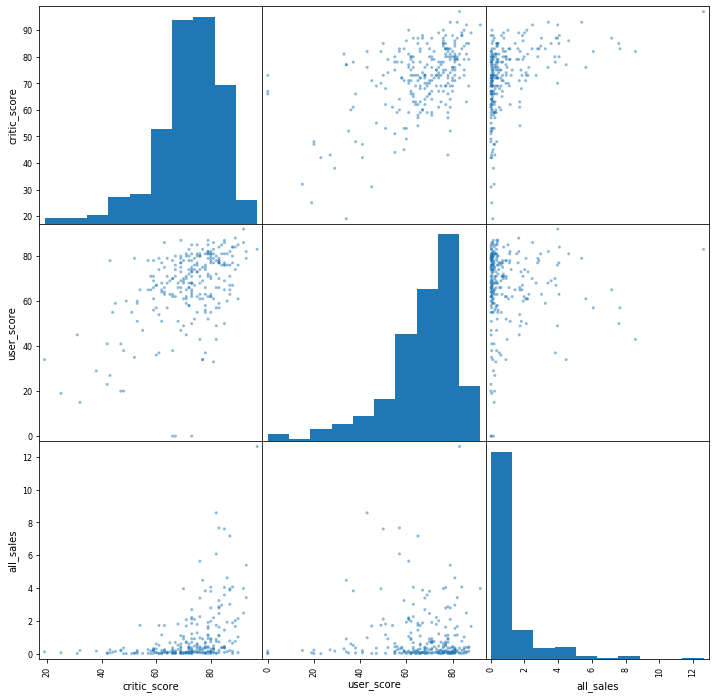

In [39]:
pd.plotting.scatter_matrix(data_ps4_score, figsize=(12, 12))

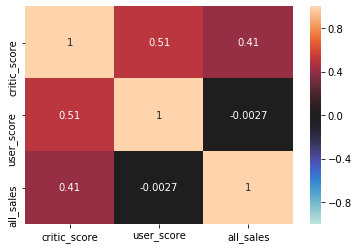

In [40]:
sns.heatmap(data_ps4_score.corr(), annot=True, vmin=-1, vmax=1, center=0)

### Вывод: 
Влияние оценки критиками - достаточно высоко, коэффициент корреляции 0.41. Что заметно и по таблице, самые высокие продажи у игр с высокими оценками от критиков. Влияние оценки пользователей в свою очередь не так заметно (корреляций близка к 0), самые пиковые значения по продажам находятся ближе к срединным оценкам пользователей. Возможно, это связано с тем, что игры с высокой оценкой пользуются спросом только у узкого круга людей (например, не самые распространенные жанры).

### Анализ продаж по всем остальным платформам

Проделываем аналогичные действия предыдущей аналитике, только в этот раз выбираем все платформы кроме ps4.

In [41]:
data_not_ps4 = data.query('platform != "ps4"')
data_not_ps4.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Grand Theft Auto V,ps3,2013,action,7.02,9.09,0.98,3.96,97,82,M,21.05
1,Grand Theft Auto V,x360,2013,action,9.66,5.14,0.06,1.41,97,81,M,16.27
2,Call of Duty: Modern Warfare 3,x360,2011,shooter,9.04,4.24,0.13,1.32,88,34,M,14.73
4,Pokemon X/Pokemon Y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,0,0,not_rating,14.60
5,Call of Duty: Black Ops II,ps3,2012,shooter,4.99,5.73,0.65,2.42,83,53,M,13.79
6,Call of Duty: Black Ops II,x360,2012,shooter,8.25,4.24,0.07,1.12,83,48,M,13.68
7,Call of Duty: Modern Warfare 3,ps3,2011,shooter,5.54,5.73,0.49,1.57,88,32,M,13.33
8,Mario Kart 7,3ds,2011,racing,5.03,4.02,2.69,0.91,85,82,E,12.65
10,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,0,0,not_rating,11.68
11,Super Mario 3D Land,3ds,2011,platform,4.89,3.00,2.14,0.78,90,84,E,10.81


In [42]:
data_not_ps4_score = data_not_ps4[{'critic_score', 'user_score', 'all_sales'}]
data_not_ps4_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 0 to 4021
Data columns (total 3 columns):
critic_score    3630 non-null int64
user_score      3630 non-null int64
all_sales       3630 non-null float64
dtypes: float64(1), int64(2)
memory usage: 113.4 KB


In [43]:
data_not_ps4_score = data_not_ps4_score.query('user_score != 0' and 'critic_score != 0')
data_not_ps4_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 0 to 4016
Data columns (total 3 columns):
critic_score    1560 non-null int64
user_score      1560 non-null int64
all_sales       1560 non-null float64
dtypes: float64(1), int64(2)
memory usage: 48.8 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0a20afa50>,
      dtype=object)

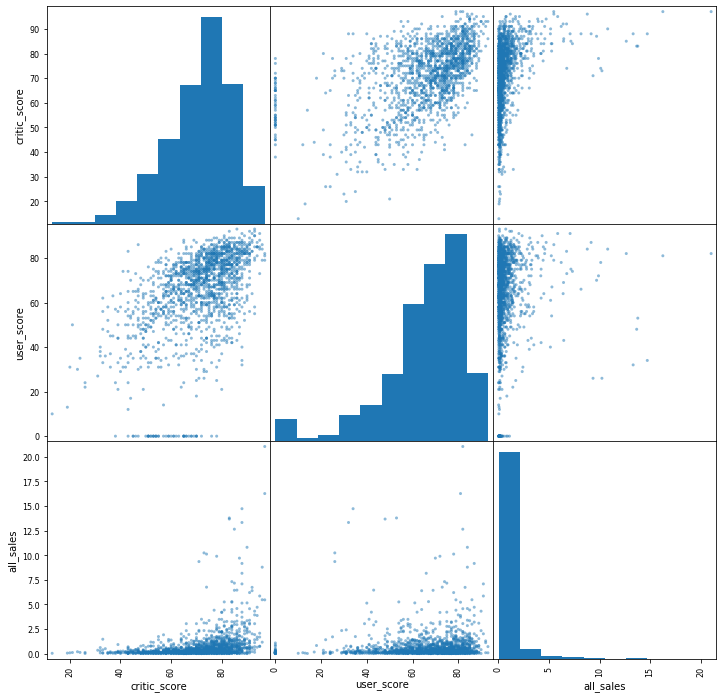

In [44]:
pd.plotting.scatter_matrix(data_not_ps4_score, figsize=(12, 12))

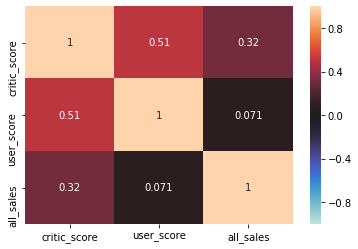

In [45]:
sns.heatmap(data_not_ps4_score.corr(), annot=True, vmin=-1, vmax=1, center=0)

### Вывод:
Вывод примерно похож на предыдущий. Корреляция влияния оценки пользователями чуть выше, но все так же близка к 0. Но, следует учесть, что самые пиковые значения по продажам имеют высокие рейтинги пользователей, в отличии от PS4, а значит влияение на других платформах чуть больше.
Оценка же критиками все так же влияет на выбор пользователей, игры с самыми высоками продажами имеют и высокие рейтинги от критиков. Коэффициент корреляции же в данном случае чуть ниже (0.32, когда в ps4 был 0.41), что можно обосновать тем, что игр со средним и невысоким рейтингом с продажами тут куда больше.


Тот факт, что оценки критиков влияют на выбор больше чем оценки пользователей объясняется тем, что оценки критиков это в первую очередь оценки профессионалов, тех кто объективно анализирует, делает вывода, а так же указывает сильные и слабые стороны.
Отзывы пользователей же имеют часто субъективную оценку, а значит отзыв мы получаем искаженным личным мнением и предпочтениями пользователей. Так же, есть люди, которые просто могут любить определенную серию игр или жанр, а значит будут ставить им завышенные оценки. 

У ps4 влияение отзыва критиков чуть выше. Возможно, игры помимо хороших отзывов - так же получают и хорошую рекламу, а значит при анализе перспективных игр в первую очередь акцент следует делать на те игры, которые активно оценивают критики достаточно высоко.
    
Отдельно так же рассмотрим вторую самую перспевтивную платформу - xone.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0a1c60b50>,
      dtype=object)

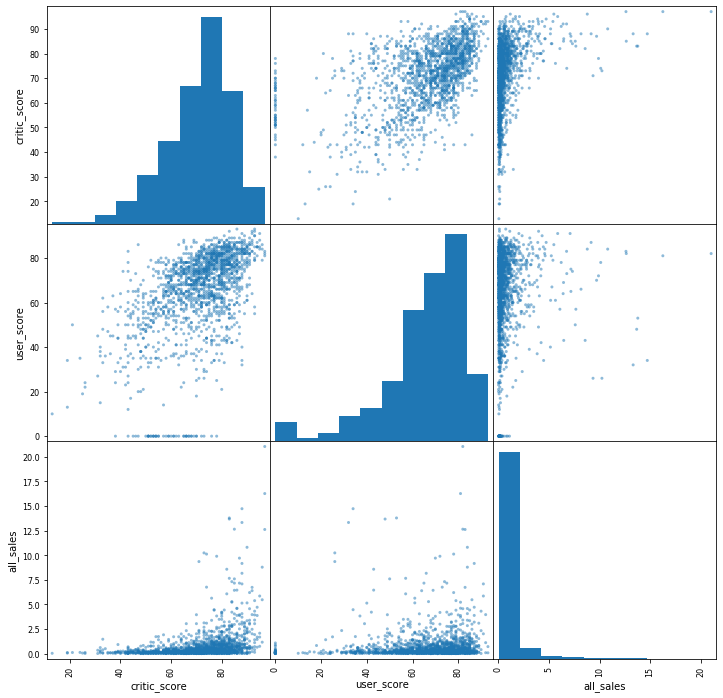

In [46]:
data_xone = data.query('platform != "xone"')
data_score_xone = data_xone[{'critic_score', 'user_score', 'all_sales'}]
data_score_xone = data_score_xone.query('user_score != 0' and 'critic_score != 0')
pd.plotting.scatter_matrix(data_score_xone, figsize=(12, 12))

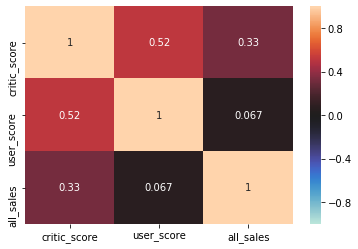

In [47]:
sns.heatmap(data_score_xone.corr(), annot=True, vmin=-1, vmax=1, center=0)

### Вывод:
Коэффициент корреляции на уровне продаж всех платформ без ps4. 

Игры с самым высокими рейтингами продаются больше всего (что опять-таки обосновывается корректностью мнения критиков и тому, что покупатели верят оценкам критиков). 

Разброс по оценкам пользователями немного иной - есть игры с невысокими рейтингами от пользователей, но с достаточно высокими продажами, а значит есть игры, которые имеют свою аудиторию, а так же ту аудиторию - который просто данные жанры или серии игр не нравятся (мненее тут более субъективно). 

### Влияние жанра на продажи

In [48]:
# посчитаем продажи по жанрам (сумма и количество)
# сначала отсортируем по сумме
data_genre = data.pivot_table(index='genre', values='all_sales', aggfunc={'sum', 'count'})
data_genre = data_genre.sort_values(by='sum', ascending=False)
data_genre.head(30)

,count,sum
genre,,
action,1269,557.80
shooter,329,402.91
role-playing,465,245.63
sports,389,237.15
misc,375,139.42
platform,122,88.68
racing,180,88.31
fighting,159,66.90
simulation,136,50.26


In [49]:
# сортируем по продажам в штуках
data_genre.sort_values(by='count', ascending=False)

,count,sum
genre,,
action,1269,557.80
role-playing,465,245.63
adventure,410,45.04
sports,389,237.15
misc,375,139.42
shooter,329,402.91
racing,180,88.31
fighting,159,66.90
simulation,136,50.26


In [50]:
# можно высчитать среднюю стоимость игр каждого жанра
data_genre['price']=data_genre['sum'] / data_genre['count']

data_genre.sort_values(by='price', ascending=False).head(15)

,count,sum,price
genre,,,
shooter,329,402.91,1.224650
platform,122,88.68,0.726885
sports,389,237.15,0.609640
role-playing,465,245.63,0.528237
racing,180,88.31,0.490611
action,1269,557.80,0.439559
fighting,159,66.90,0.420755
misc,375,139.42,0.371787
simulation,136,50.26,0.369559


### Вывод:
Безусловным лидером является жанр action. Так же следует выделить такие жанры как role-playing, sports, misc, shooter (которые стабильно хорошо продаются как в штуках, так и по сумме продаж). Жанр adventure продается в больших количествах (3 место по продажам в штуках), но при этом дает небольшой оборот (3 место с конца по продаже в деньгах).

Хуже всего продаются как в штуках, так и в сумме жанры puzzle и strategy. 

Самые дорогие игры выходят в жанре shooter, благодарю чему несмотря на не самые высокие продажи в штуках (6 место), по сумме они дают очень высокий показатель (2 место). Жанр action находится в середине списка по стоимости, но благодаря очень большому количеству в штуках лидирует во всех списках.

## Общий вывод:
Из проделанной работы можно сделать следующие выводы:

    1) Самые популярные и развивающиеся платформы на данный момент - ps4 и xone.
    2) Сконцентрироваться лучше на играх с высокими оценками от критиков, пользовательские оценки имеют меньшее значение.
    3) Самые продаваемый жанр по сумме и штуках - action (на него основной акцент).
    4) Так же хороший оборот дают жанры shooter, role-playing, sports, misc.
    5) Можно попробовать брать и штуками, для этого сделать акцент на жанр adventure.

<a id='id_4'></a>
# 4) Портреты пользователей каждого региона

## Регион Северная Америка (NA)

In [51]:
# уберем из датафрейма все неинтересующие нас строки
data_na = data[{'platform', 'na_sales', 'genre', 'rating'}]
data_na.head(15)

,platform,genre,rating,na_sales
0,ps3,action,M,7.02
1,x360,action,M,9.66
2,x360,shooter,M,9.04
3,ps4,shooter,not_rating,6.03
4,3ds,role-playing,not_rating,5.28
5,ps3,shooter,M,4.99
6,x360,shooter,M,8.25
7,ps3,shooter,M,5.54
8,3ds,racing,E,5.03
9,ps4,action,M,3.96


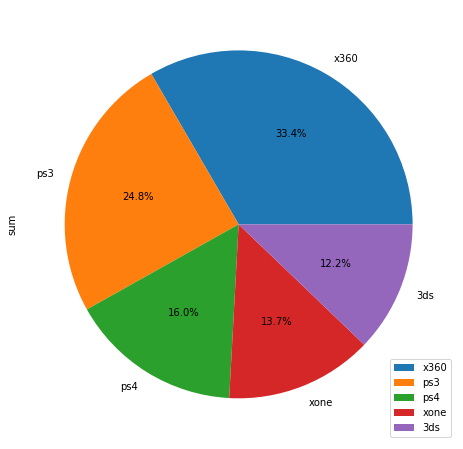

In [52]:
# посчитаем самые популярные платформы
data_na_plat = data_na.pivot_table(index='platform', values='na_sales', aggfunc={'sum', 'count'})
data_na_plat.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(8, 8))

<div class="alert alert-warning">
<h2> Исправления </h2>
 
Далее, будут созданы столбчатые диаграммы по аналогии с пироговыми (их я использовал для наглядности процентного соотношения).
Пироговые диаграммы я удалить не буду.

Так же при анализе рейтинга - будут учитываться группа игр, у которых рейтинг не был указан как отдельная группа.
</div>

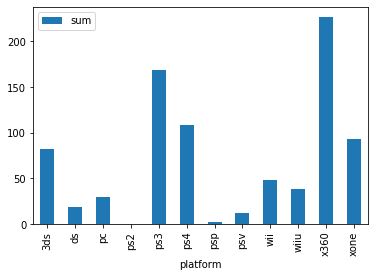

In [53]:
data_na_plat_sum = data_na.pivot_table(index='platform', values='na_sales', aggfunc='sum')
data_na_plat_sum.plot(kind='bar')

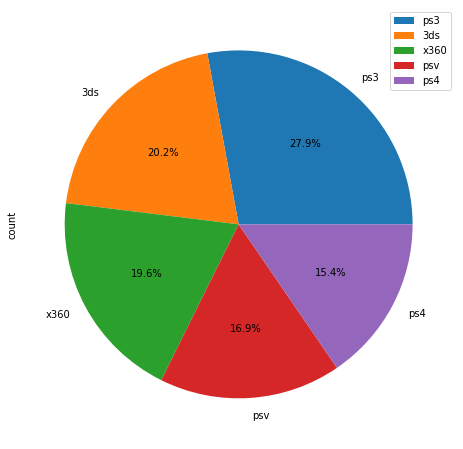

In [54]:
data_na_plat.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(8, 8), autopct='%1.1f%%')

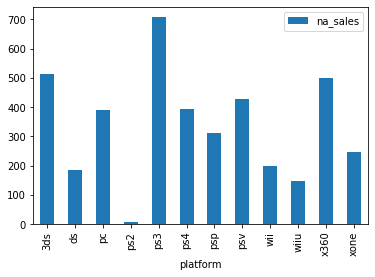

In [71]:
data_na_plat_count = data_na.pivot_table(index='platform', values='na_sales', aggfunc='count')
data_na_plat_count.plot(kind='bar')

По сумме продаж ТОП-5 составили следующие платформы: x360 (33.4%), ps3(24.8%), ps4(16%), xone(13.7%), 3ds(12.2%).
Самое высокое значение имеет x360 (треть всех продаж среди ТОП-5). Четверть от всех продаж имеет ps3.
По количеству продаж ТОП-5 составили: ps3 (27.9%), 3ds (20.2%), x360 (19.6%), psv (16.9%), ps4 (15.4%).
Лидер - ps3, разница у платформ не такая уж и большая.
Самые продаваемая по сумме платформа всего-лишь третья по количеству (возможно, игры x360 - самые распространенные, но их количество не такое уж и большое).

<function matplotlib.pyplot.show(*args, **kw)>

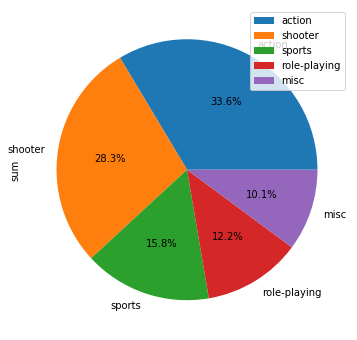

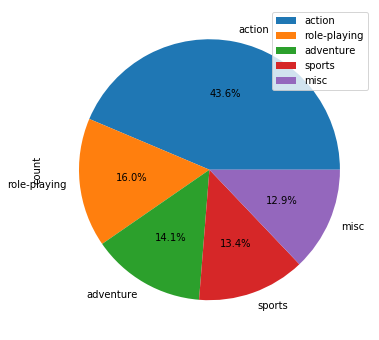

In [55]:
# аналогично проанализируем жанры
data_na_genre = data_na.pivot_table(index='genre', values='na_sales', aggfunc={'sum', 'count'})
data_na_genre.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_na_genre.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')
plt.show

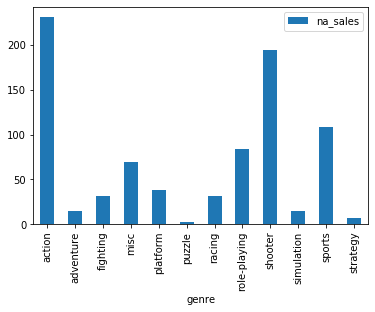

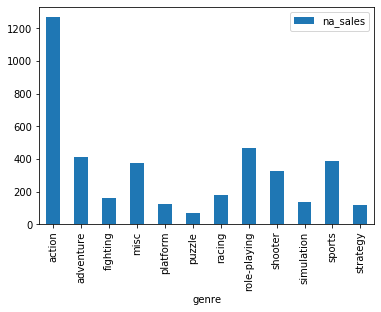

In [72]:
data_na_genre_sum = data_na.pivot_table(index='genre', values='na_sales', aggfunc='sum')
data_na_genre_count = data_na.pivot_table(index='genre', values='na_sales', aggfunc='count')
data_na_genre_sum.plot(kind='bar')
data_na_genre_count.plot(kind='bar')

ТОП-5 по сумме: action (33.6%), shooter (28.3%), sports (15.8%), role_playing (12.2%), misc (10.1%).
ТОП-5 по количеству: action (43.6%), role-playing (16%), adventure (14.1%), sports (13.4%), misc (12.9%).
Как было выяснено ранее - жанр adventure один из самых распространенных, но малооборачиваемых, поэтому входя в топ по штукам, он не входит в топ по количеству. Жанр shooter - напротив, самый редкий, но востребованный, поэтому хоть он и в топе по сумме, в топе по штукам его нет.

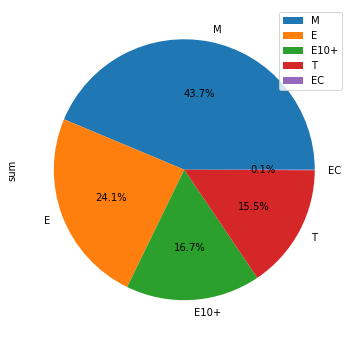

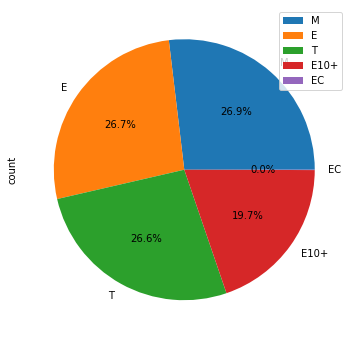

In [56]:
# проверим, влияет ли рейтинг на продажи в регионе, для этого удалим все значения без рейтинга
data_na_rating = data_na.query('rating != "not_rating"')
data_na_rating = data_na_rating.pivot_table(index='rating', values='na_sales', aggfunc={'sum', 'count'})
data_na_rating.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_na_rating.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')

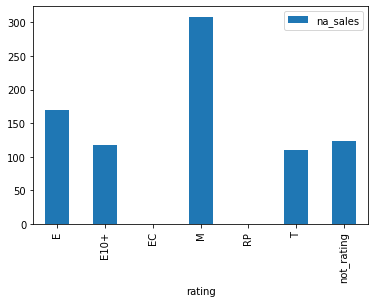

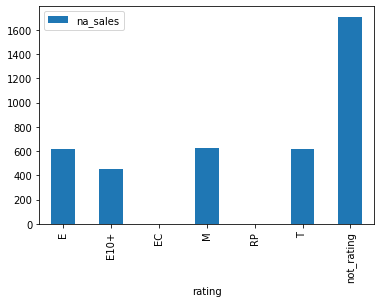

In [73]:
data_na_rating_sum = data_na.pivot_table(index='rating', values='na_sales', aggfunc='sum')
data_na_rating_count = data_na.pivot_table(index='rating', values='na_sales', aggfunc='count')
data_na_rating_sum.plot(kind='bar')
data_na_rating_count.plot(kind='bar')

Большинство игр по сумме идут с рейтингом M(43.7%), E(24.1%), T(16.7%), E10+(15.5%). 
По штукам : M(26.9%), E (26.7%), T (26.6%), E10+ (19.7%). Разбос в штуках невысокий, а значит вся разница по сумме из-за востребованности самих игр.

Количество игр без рейтинга - намного больше чем других игр, но исходя из суммы продаж можно сделать вывод, что эти игры стоят не так уж и дорого. Скорее всего это распространенные небольшие игры.

## Регион Европа(EU)

In [57]:
# действуем по аналогии с регионом Америка
data_eu = data[{'platform', 'eu_sales', 'genre', 'rating'}]
data_eu.head(15)

,platform,genre,eu_sales,rating
0,ps3,action,9.09,M
1,x360,action,5.14,M
2,x360,shooter,4.24,M
3,ps4,shooter,5.86,not_rating
4,3ds,role-playing,4.19,not_rating
5,ps3,shooter,5.73,M
6,x360,shooter,4.24,M
7,ps3,shooter,5.73,M
8,3ds,racing,4.02,E
9,ps4,action,6.31,M


<function matplotlib.pyplot.show(*args, **kw)>

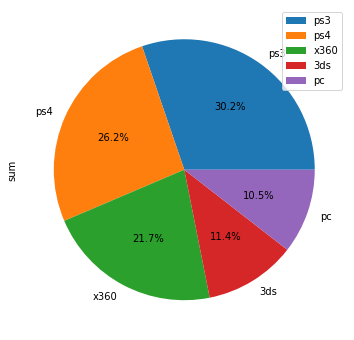

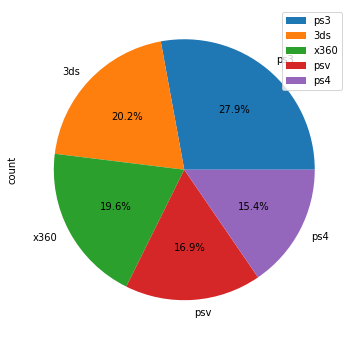

In [58]:
data_eu_plat = data_eu.pivot_table(index='platform', values='eu_sales', aggfunc={'sum', 'count'})
data_eu_plat.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_eu_plat.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')
plt.show

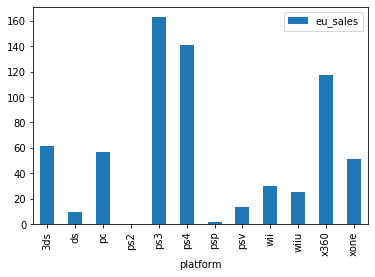

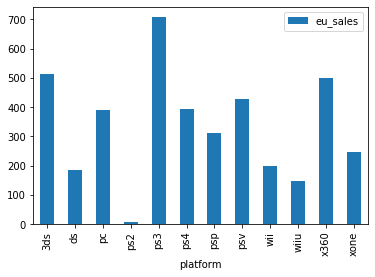

In [74]:
data_eu_plat_sum = data_eu.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
data_eu_plat_sum.plot(kind='bar')
data_eu_plat_count = data_eu.pivot_table(index='platform', values='eu_sales', aggfunc='count')
data_eu_plat_count.plot(kind='bar')

ТОП-5 по сумме: ps3 (30.2%), ps4 (26.2%), x360 (21.7%), 3ds (11.4%), pc (10.5%).
ТОП-5 по штукам: ps3 (27.9%), 3ds (20.2%), x360 (19.6%), psv (16.9), ps4 (15.4%)
Лидер - ps3, как по штукам так и по сумме. Стабильно продается x360 (около 20%) как по сумме, так и по штукам. 
Игр платформы 3ds больше чем ps4, но они менее востребованы, в следствии чего хоть ps4 2 по сумме, а 3ds - 4 по сумме, по штукам они меняются (ps4 - 4, 3ds -2)

<function matplotlib.pyplot.show(*args, **kw)>

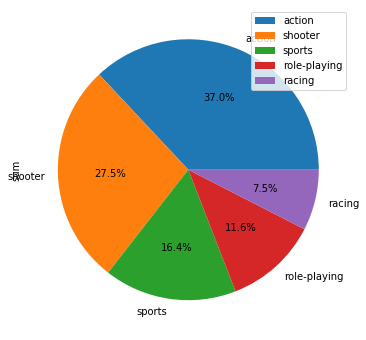

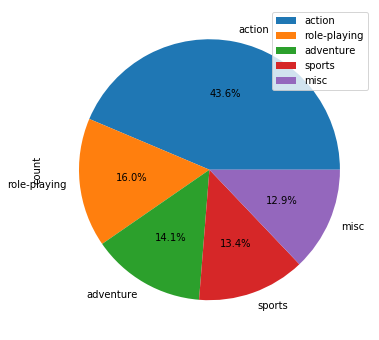

In [59]:
data_eu_genre = data_eu.pivot_table(index='genre', values='eu_sales', aggfunc={'sum', 'count'})
data_eu_genre.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_eu_genre.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')
plt.show

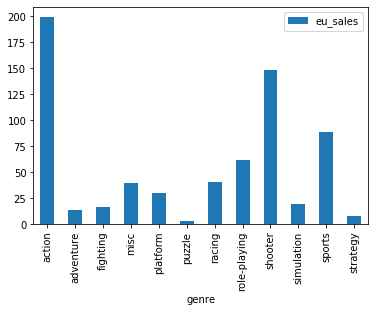

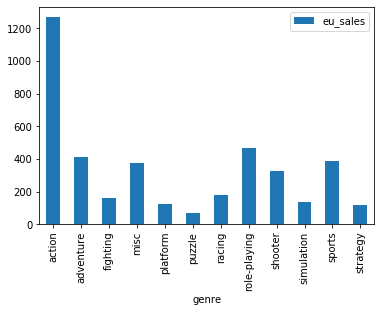

In [76]:
data_eu_genre_sum = data_eu.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
data_eu_genre_count = data_eu.pivot_table(index='genre', values='eu_sales', aggfunc='count')
data_eu_genre_sum.plot(kind='bar')
data_eu_genre_count.plot(kind='bar')

ТОП-5 по сумме: action (37%), shooter (27.5%), sport (16.4%), role-playing (11.6%), racing (7.5%).
ТОП-5 по количеству: action (43.6%), role-playing (16%), adventure (14.1%), sports (13.4%), misc (12.9%).
Action - безусловный лидер. Второе место по сумме shooter, но из-за небольшого количества игр его нет в топе по штукам. Напротив, из-за ба adventure находясь на 3 месте в топе по штукам в топ по суммне не попадает

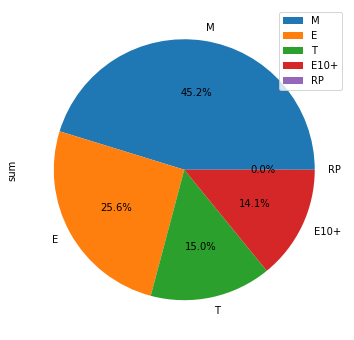

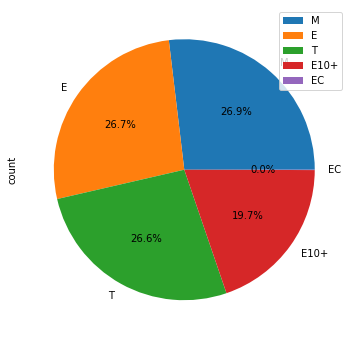

In [60]:
# проверим, влияет ли рейтинг на продажах в европе
data_eu_rating = data_eu.query('rating != "not_rating"')
data_eu_rating = data_eu_rating.pivot_table(index='rating', values='eu_sales', aggfunc={'sum', 'count'})
data_eu_rating.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_eu_rating.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')

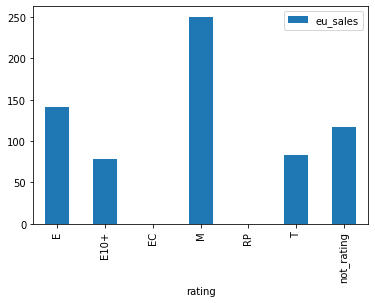

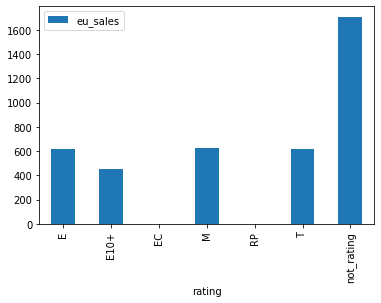

In [77]:
data_eu_rating_sum = data_eu.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
data_eu_rating_count = data_eu.pivot_table(index='rating', values='eu_sales', aggfunc='count')
data_eu_rating_sum.plot(kind='bar')
data_eu_rating_count.plot(kind='bar')

Большинство игр по сумме идут с рейтингом M(45.2%), E(25.6%), T (15%), E10+(14.1%). 
По штукам : M(26.9%), E (26.7%), T (26.6%), E10+ (19.7%). Разбос в штуках невысокий, а значит вся разница по сумме из-за стоимости самих игр

## Регион Япония (JP)

<function matplotlib.pyplot.show(*args, **kw)>

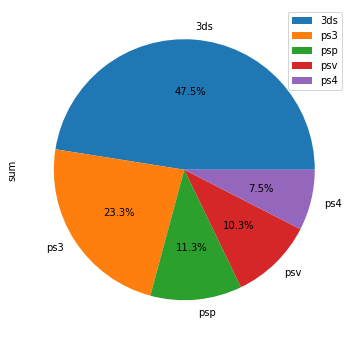

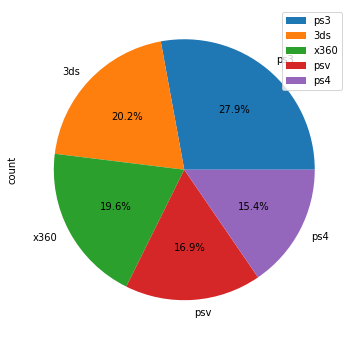

In [61]:
# продажи по платформам
data_jp = data[{'platform', 'jp_sales', 'genre', 'rating'}]
data_jp_plat = data_jp.pivot_table(index='platform', values='jp_sales', aggfunc={'sum', 'count'})
data_jp_plat.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_jp_plat.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')
plt.show

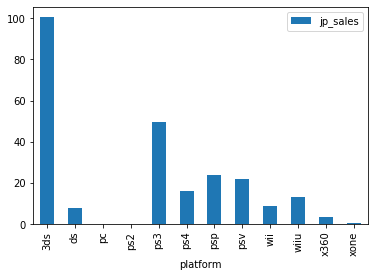

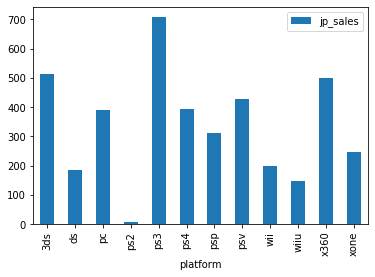

In [78]:
data_jp_plat_sum = data_jp.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
data_jp_plat_sum.plot(kind='bar')
data_jp_plat_count = data_jp.pivot_table(index='platform', values='jp_sales', aggfunc='count')
data_jp_plat_count.plot(kind='bar')

ТОП-5 по сумме: 3ds (47.5%), ps3 (23.3%), psp (11.3%), psv (10.3%), ps4(7.5%).
ТОП-5 по количеству: ps3(27.9%), 3ds (20.2%), x360(19.6%), psv (16.9%), ps4 (15.4%)
Довольно стабильно, единственная разница - 3ds из-за более высоких продаж на 1 месте по сумме, но количество игр - меньше чем у ps3. Платформа x360 - в штуках по продажам на 3 месте, но из-за невысоких продаж в топ-5 по сумме даже не попала. Напротив, psp - третьи по сумме, но в топ по количеству не попали.

<function matplotlib.pyplot.show(*args, **kw)>

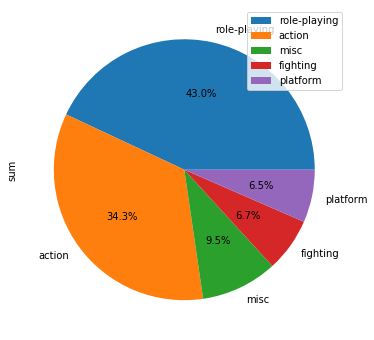

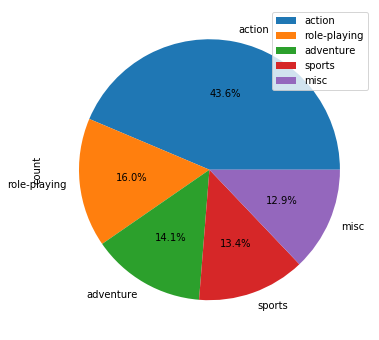

In [62]:
# продажи по жанрам
data_jp_genre = data_jp.pivot_table(index='genre', values='jp_sales', aggfunc={'sum', 'count'})
data_jp_genre.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_jp_genre.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')
plt.show

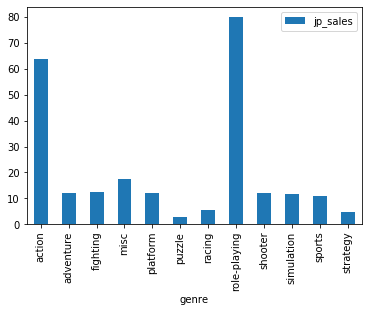

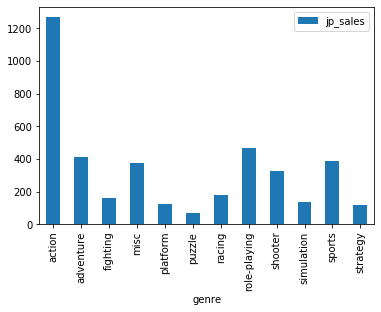

In [79]:
data_jp_genre_sum = data_jp.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
data_jp_genre_count = data_jp.pivot_table(index='genre', values='jp_sales', aggfunc='count')
data_jp_genre_sum.plot(kind='bar')
data_jp_genre_count.plot(kind='bar')

ТОП-5 по сумме: role-playing (43%), action (34.3%), misc (9.5%), fighting (6.7%), platform (6.5%).

ТОП-5 по количеству: action (43.6%), role-playing(16%), adventure (14.1%), sports (13.4%), misc (12.9%).

Игры жанра role-playing продаются в Японии куда больше остальных (43%), так же хорошо продается action (34.5%), все остальные игры продаются не больше 10%. По количеству игр - явный лидер жанр action (43.6%), все остальные от 13 до 16%. 


 Разница в играх по сравнению с Европой и Северной Америкой характеризуется влияением высокой популярности платформы 3ds в Японии, из-за которой жанры игр и были смещены.
Европа и Америка в целом же похоже в связи с тем, что преобладающие платформы в них (ps4, ps3, xone, x360) - похожи между собой, популярные жанры на этих платформах достаточно похожи


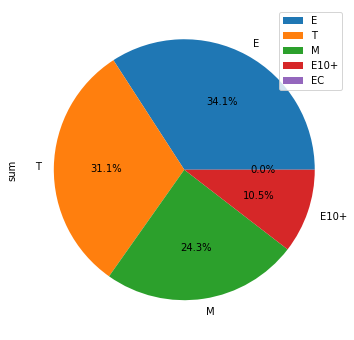

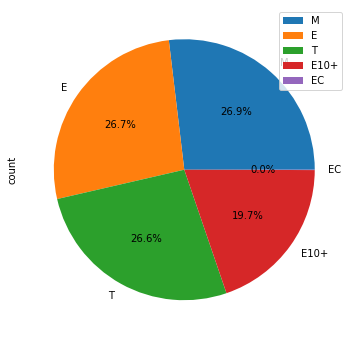

In [63]:
# проверим влияение возрастного рейтинга
# проверим, влияет ли рейтинг на продажах в европе
data_jp_rating = data_jp.query('rating != "not_rating"')
data_jp_rating = data_jp_rating.pivot_table(index='rating', values='jp_sales', aggfunc={'sum', 'count'})
data_jp_rating.sort_values(by='sum', ascending=False).head(5).plot(kind='pie', y='sum', autopct='%1.1f%%', figsize=(6, 6))
data_jp_rating.sort_values(by='count', ascending=False).head(5).plot(kind='pie', y='count', figsize=(6, 6), autopct='%1.1f%%')

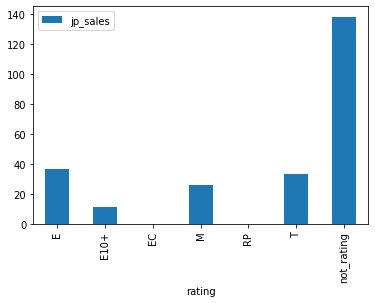

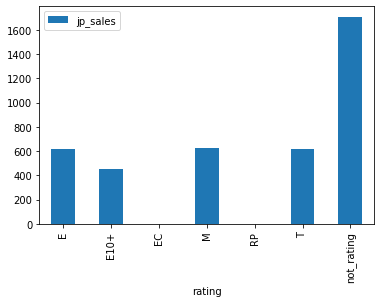

In [80]:
data_jp_rating_sum = data_jp.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
data_jp_rating_count = data_jp.pivot_table(index='rating', values='jp_sales', aggfunc='count')
data_jp_rating_sum.plot(kind='bar')
data_jp_rating_count.plot(kind='bar')

Большинство игр по сумме идут с рейтингом E(34.1%), T(31.1%), M(24.3%), E10+(10.5%). 
По штукам : M(26.9%), E (26.7%), T (26.6%), E10+ (19.7%). Разбос в штуках невысокий, а значит вся разница по сумме из-за стоимости самих игр.

Отдельно отметим тот факт, что по сумме продаж в Японии преобладает список игр, у которых рейтинг не указан. А значит основные популярные игры в Японии отличаются от игр в Европа и Северной Америке (что еще раз объясняет разницу в предпочитаемых платформах и жанрах, если Европу и Америку сравнивать с Японией)

# Общий вывод:

    1) По платформам: в Америке по сумме лидирует x360, в Европе лидирует ps3, в Японии же 3ds (с большим отрывом от         преследователя ps3). Во всех 3 регионах в топ 5 входят три следующих жанра: ps3, 3ds, ps4. Если в Европе и Америке      разница не сильно критичная, то в Японии заметно явное лидерство 3ds(47.5% - почти половина от суммы всего ТОП5).    
    
    2) По жанрам: в Европе и Америке ТОП5 по жанрам очень похожи (первые 4 жанра action, shooter, sports, role-playing  идут в одинаковом порядке и имеют примерно похожее процентное соотношение), в то время как в Японии лидируют с большим       отрывом всего 2 жанра: role-playing (43%), action (34.5%), а жанры shooter и sports в ТОП-5 не попали вообще. 
   
    3) По рейтингу: опять заметно схожесть Европы и Америки, жанры идут в одинаковом порядке и имеют примерно похожее       соотношение M, E, игры без рейтинга, T, E10+. В Японии же порядок и соотношение совершенно иные: E(34.1%), T(31.1%), M(24.3%), E10+(10.5%). в Японии преобладает список игр, у которых рейтинг не указан с большим отрывом от остальных.
    

<a id='id_5'></a>
# 5) Проверка гипотез:

### Средние пользовательские рейтинги платформ xone и pc одинаковые

In [64]:
# Нулевая гипотеза: средние пользовательские рейтинги платформ xone и pc одинаковые
# Альтернативная гипотеза: средние пользовательские рейтинги платформ xone и pc различаются
# Для начала создадим 2 датафрейма (платформа xone и платформа pc) удалим все 0 значения из столбца с рейтингами
data_pc = data.query('user_score != 0').query('platform == "pc"').reset_index(drop=True)
data_xone = data.query('user_score != 0').query('platform =="xone"').reset_index(drop=True)
data_xone.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Grand Theft Auto V,xone,2014,action,2.81,2.19,0.00,0.47,97,79,M,5.47
1,Call of Duty: Advanced Warfare,xone,2014,shooter,3.22,1.55,0.01,0.48,81,54,M,5.26
2,Halo 5: Guardians,xone,2015,shooter,2.78,1.27,0.03,0.41,84,64,T,4.49
3,Fallout 4,xone,2015,role-playing,2.51,1.32,0.01,0.38,88,62,M,4.22
4,Assassin's Creed: Unity,xone,2014,action,2.27,0.90,0.00,0.33,72,41,M,3.50
5,Destiny,xone,2014,shooter,2.14,0.92,0.00,0.31,75,55,T,3.37
6,Gears of War: Ultimate Edition,xone,2015,shooter,2.61,0.33,0.00,0.34,82,75,M,3.28
7,FIFA 16,xone,2015,sports,0.89,2.12,0.00,0.24,84,44,E,3.25
8,Halo: The Master Chief Collection,xone,2014,shooter,1.91,1.00,0.03,0.29,85,72,M,3.23
9,Titanfall,xone,2014,shooter,1.84,0.80,0.04,0.27,86,64,M,2.95


In [87]:
# проверим гипотезу
# т.к. проверяем двустороннюю теорию двух генеральных совокупностей - используем методм st.ttest_ind
alpha = 0.05
results = st.ttest_ind(data_pc['user_score'], data_xone['user_score'], axis=0, equal_var=False)
results

Ttest_indResult(statistic=-0.5060666492177384, pvalue=0.613071224763855)

In [85]:
# напишем функцию
if results.pvalue >= alpha:
    print('Средние пользовательские рейтинги равны, нет причин отвергать гипотезу')
elif results.pvalue < alpha:
    print('Средние пользовательские рейтинги не равны, нулевую теорию отвергаем')

Средние пользовательские рейтинги равны, нет причин отвергать гипотезу


___Теория проверена, средние пользовательские рейтинги игр xone и pc равны___

## Средние пользовательские рейтинги жанров Action  и Sports разные.

__Нулевая гипотеза__: средние пользовательские рейтинги жанров Action и Sports равны.

__Альтернативная гипотеза будет следующей__: средние пользовательские рейтинги жанров Action и Sports не равны.

In [110]:
# посчитаем дисперсию
np.var(data_action['user_score'])

180.9148279866454

In [111]:
np.var(data_sports['user_score'])

287.07920219446095

In [118]:
alpha = 0.05
results2 = st.ttest_ind(data_action['user_score'], data_sports['user_score'], equal_var=False)
results2

Ttest_indResult(statistic=9.360735032170032, pvalue=8.285648549432146e-19)

In [119]:
if results2.pvalue < alpha:
    print('Нулевую теорию отвергаем, средние пользовательские рейтинги жанров Action и Sports не равны')
elif results2.pvalue >= alpha:
    print('Нет причин отвергать нулевую теорию, средние пользовательские рейтинги жанров Action и Sports равны')

Нулевую теорию отвергаем, средние пользовательские рейтинги жанров Action и Sports не равны


___Cредние пользовательские рейтинги жанров Action и Sports не равны, а значит нулевую теорию отвергаем___

<a id='id_6'></a>
# 6) Общий вывод:

Можно сделать общие выводы:

    1) Для анализа продаж лучше всего подходит период с 2012 по 2015 год, так же в статистику можно включить и 2016 год, но данные за него скорее всего неполные.
    2) Самая продаваемая платформа - PS4, следом за ней идет XOne (но продажи почти в два раза меньше чем у PS4). Так же    неплохо продается платформа 3DS, но суммы уже в 5 раз меньше чем PS4. 
    3) Влияение оценки критиков куда выше влияние оценки пользователей. При анализе в первую очередь следует отталкиваться  от оценки критиков.
    4) Лидер продаж по жанрам - action, так же хорошо продаются role-playing, sports, misc, shooter. Игр жанра adventure    очень много, но они дают небольшое количество оборота по сумме.
    5) Хуже всего продаются жанры puzzle и strategy.
    6) Статистика продаж по регионам:
        - платформы: в Америке лидер -X360, в Европе - PS3, в Японее 3DS (с большим отрывом от других жанров). Во всех регионах в ТОП-5 попадают жанры: ps4, ps3, 3ds. 
        - жанры: в Америке и Европе преобладают action. shooter, sports, roly-playing (достаточно похоже по обоим регионам), в Японии же в лидерах roly-playing и action (с большим отрывом от остальных жанров), жанры shooter и sports в Японии не в ТОП-5.
        - рейтинг: ЕвропА и Америка похожи, жанры идут в одинаковом порядке и имеют примерно похожее процентное соотношение M (43.5% и 45.2%), E (24.1% и 25.6%), T (16.7% и 15%), E10+ (15.5% и 14.1%). В Японии  порядок и процентное соотношение совершенно иные: E(34.1%), T(31.1%), M(24.3%), E10+(10.5%).
    7) Средние пользовательские рейтинги игр XONE и PC равны.
    8) Средние пользовательские рейтинги жанров Action и Sports разные.